**MNIST example in colab**

---


Mount your drive and check

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


**Load data for testing**

1. drive/My Drive/public/data/ has data
2. drive/My Drive/public/results/ will have results


* copy images from ./tutorials-master downloaded directory into drive/My Drive/public/data/mnist_test_images/


**Classification task with a Feedforward Network** \\

\\

In this notebook, we will learn to perform a classification task using a feedforward neural network. Pytorch libraries provide the necessay tools for a simple and intuitive implementation. Let's start! \\
First we have to know the task and the data. In this case, we are going to do a image classification task, which means that the input to our model will be images (pixel values), and the output will be a label. In this case, we will use MNIST dataset, which consists in digital hadwritten digits from 0-9, with their corresponding labels. The dimension of the images is 28x28. \\
Pytorch automatically will download and split the dataset into training and testing dataset:


*   60000 images to train
*   10000 images to test

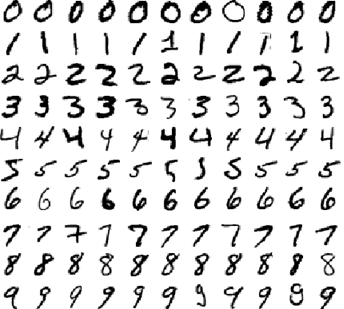

Import pytorch and other libraries.

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Define your network model. Pytorch library torch.nn provides a sub-module to wrap your neural network. The initialization of the weights occurs in the __init__ method, where we define the structure of our network. For example, let's say we have a feedforward network with four layers (3 hidden layers and the output layer.) We can define a linear layer by using nn.Linear(in_dim, n_neuron), where in_dim is the input dimension of the layer and n_neuron is the number of neurons in that layer. \\
Pytorch will always pass the input through our architecture in the forward method. Ather the input x goes through the model, we apply softmax to get the probabilities of our model. Notice that the input dimension of the first layer is 784 = 28x28, which is the 2D image flattened. 



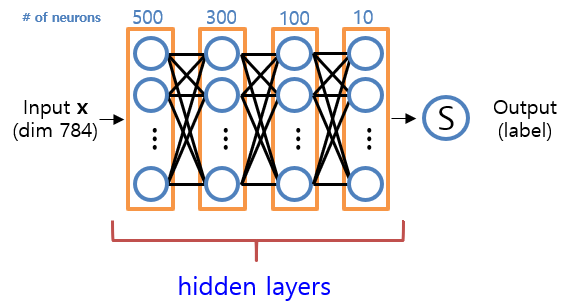

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 300)

        self.fc3 = ##COMPLETE THIS LAYER 
        
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        batch_size, c, h, w = x.data.size()
        x = x.view(batch_size, 784)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(..........)  ##COMPLETE THIS ACTIVATION
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        conv_size = self.get_conv_size((1, 28, 28))
        self.fc = nn.Sequential(
            nn.Linear(conv_size, 500), # conv_size = 4*4*50
            nn.Linear(500, 10)
        )
    
    def get_conv_size(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        batch_size, c, h, w = x.data.size() # 32*1*28*28
        x = self.conv(x)
        x = x.view(batch_size, -1) # conv_size = 4*4*50
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
"""

'\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv = nn.Sequential(\n            nn.Conv2d(1, 20, 5, 1),\n            nn.ReLU(),\n            nn.MaxPool2d(2,2),\n            nn.Conv2d(20, 50, 5, 1),\n            nn.ReLU(),\n            nn.MaxPool2d(2,2)\n        )\n        conv_size = self.get_conv_size((1, 28, 28))\n        self.fc = nn.Sequential(\n            nn.Linear(conv_size, 500), # conv_size = 4*4*50\n            nn.Linear(500, 10)\n        )\n    \n    def get_conv_size(self, shape):\n        o = self.conv(torch.zeros(1, *shape))\n        return int(np.prod(o.size()))\n\n    def forward(self, x):\n        batch_size, c, h, w = x.data.size() # 32*1*28*28\n        x = self.conv(x)\n        x = x.view(batch_size, -1) # conv_size = 4*4*50\n        x = self.fc(x)\n        return F.log_softmax(x, dim=1)\n'

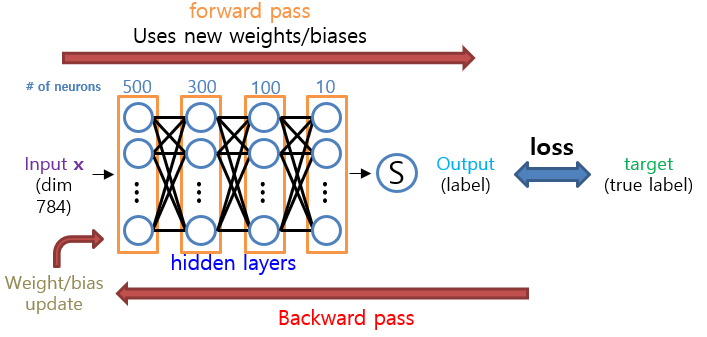

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            #torch.save(model.state_dict(),"drive/My Drive/public/results/mnist_nn.pth")


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)                        
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

---
main code 

In [ ]:
seed = 1
epochs = 2
batch_size = 32
test_batch_size = 1000
lr = 0.001
momentum = 0.9
log_interval = 100
save_model = True

torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

In [ ]:
transform=transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,)) ])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('drive/My Drive/public/data', train=True, 
                   download=True, transform=transform),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('drive/My Drive/public/data', train=False, 
                   transform=transform),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [ ]:
for batch, (data, target) in enumerate(train_loader):
  print(data)
  print('data size ', data.size())
  print(target)
  print('target size ', target.size())
  break


tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)

if (save_model):
    if not os.path.exists('drive/My Drive/public/results'):
        os.mkdir('drive/My Drive/public/results')
    torch.save(model,"drive/My Drive/public/results/mnist_nn.pth")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292150
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.896105
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.356764
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.776219
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.755939
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.505242
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.524262
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.429041
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.552105
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.274475
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.273526
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.262112
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.371868
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.108869
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.506598
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.377717
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.385981
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.426060
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.156329

Test: Average loss: 0.3009, Accuracy: 9128/10000 (91%)

Tr

In [ ]:
!ls "drive/My Drive/public/results"

cifar10_pretrained.pth	mnist_nn.pth
mnist_cnn.pth		sentiment_analysis_model_best.pth


After Training
* load the trained model
* test with one image or with one directory

In [ ]:
load_model = torch.load("drive/My Drive/public/results/mnist_nn.pth")

In [ ]:
!ls "drive/My Drive/public/data/mnist_test_images"

test_0.jpg   test_13.jpg  test_17.jpg  test_3.jpg  test_7.jpg
test_10.jpg  test_14.jpg  test_18.jpg  test_4.jpg  test_8.jpg
test_11.jpg  test_15.jpg  test_1.jpg   test_5.jpg  test_9.jpg
test_12.jpg  test_16.jpg  test_2.jpg   test_6.jpg


Model prediction:  7


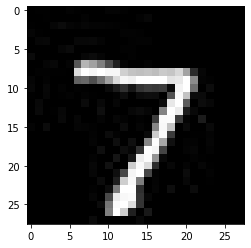

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

img_name = 'drive/My Drive/public/data/mnist_test_images/test_0.jpg'
test_img = io.imread(img_name).reshape(28,28)
test_data = transform(test_img).view(1,1,28,28).to(device)
fig = plt.figure
plt.imshow(test_img, cmap='gray')
with torch.no_grad():
  output=load_model(test_data)
print('Model prediction: ', output.argmax(dim=1).cpu().numpy()[0])
plt.show()
print(' ')

Model prediction:  7


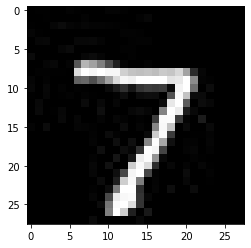

 
Model prediction:  2


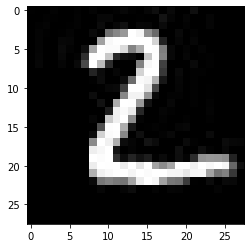

 
Model prediction:  1


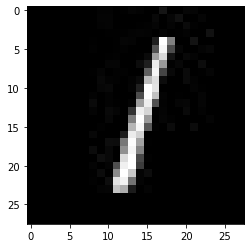

 
Model prediction:  4


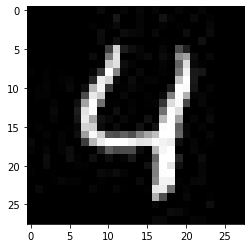

 
Model prediction:  0


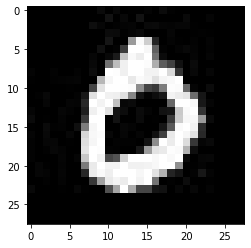

 
Model prediction:  1


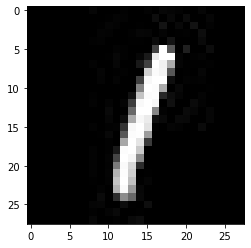

 
Model prediction:  4


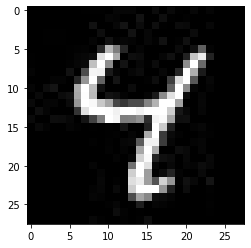

 
Model prediction:  9


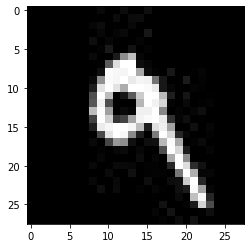

 
Model prediction:  1


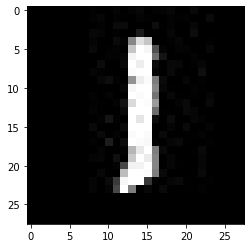

 
Model prediction:  6


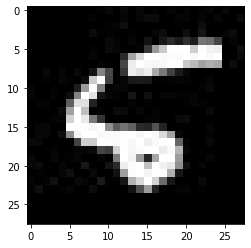

 
Model prediction:  0


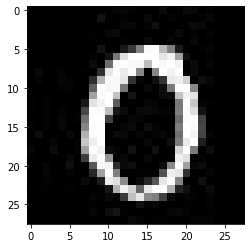

 
Model prediction:  9


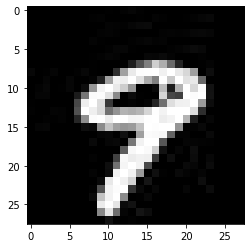

 
Model prediction:  6


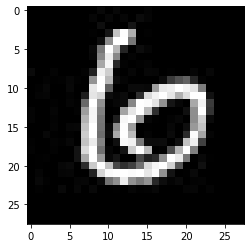

 
Model prediction:  0


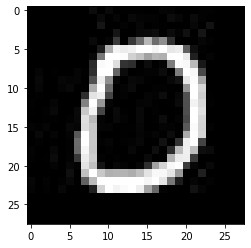

 
Model prediction:  3


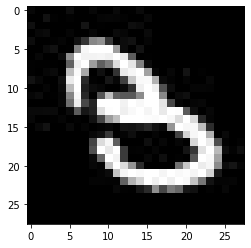

 
Model prediction:  9


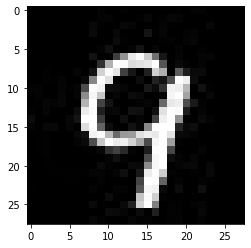

 
Model prediction:  5


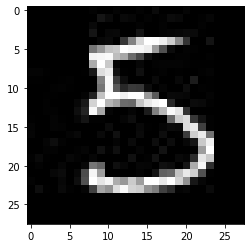

 
Model prediction:  9


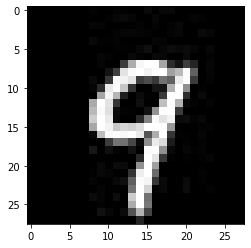

 
Model prediction:  7


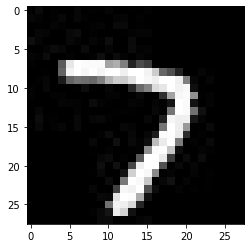

In [ ]:
from skimage import io
import glob
import matplotlib.pyplot as plt

file_list = glob.glob("drive/My Drive/public/data/mnist_test_images/*.*")
for img_name in file_list:
  test_img = io.imread(img_name).reshape(28,28)
  test_data = transform(test_img).view(1,1,28,28).to(device)
  fig = plt.figure
  plt.imshow(test_img, cmap='gray')
  with torch.no_grad():
    output=load_model(test_data)
  print('Model prediction: ', output.argmax(dim=1).cpu().numpy()[0])
  plt.show()
  print(' ')

the end! 
----